In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, DataLoader2
from pytorch_lightning.callbacks import TQDMProgressBar, LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import pytorch_lightning as pl

import torchtext
import  torchdata

import sentencepiece as spm

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

In [4]:
train, valid, test = torchtext.datasets.IWSLT2016(root='data',  language_pair=('en', 'fr'))
train_dl = DataLoader2(train, shuffle=True, batch_size=128)

In [11]:
x, y = next(iter(train_dl))
x[0], y[0]

('The small farmer in Africa today lives a life without much choice, and therefore without much freedom.\n',
 "Le petit cultivateur d'Afrique aujourd'hui a peu de choix, donc peu de liberté.\n")

In [3]:
for i, batch in enumerate(train_iter):
    print (batch)
    if i > 10:
        break

("David Gallo: This is Bill Lange. I'm Dave Gallo.\n", 'David Gallo: Voici Bill Lange. Je suis Dave Gallo.\n')
("And we're going to tell you some stories from the sea here in video.\n", 'Nous allons vous raconter quelques histoires de la mer en vidéo.\n')
("We've got some of the most incredible video of Titanic that's ever been seen, and we're not going to show you any of it.\n", "Nous avons des vidéos du Titanic parmi les plus spectaculaires jamais vues. et nous n'allons pas vous en montrer une image.\n")
("The truth of the matter is that the Titanic -- even though it's breaking all sorts of box office records -- it's not the most exciting story from the sea.\n", "La vérité est que le Titanic -- même s'il continue de battre toutes les records de recettes -- n'est pas l'histoire la plus passionnante.\n")
('And the problem, I think, is that we take the ocean for granted.\n', "Le problème, je crois, est qu'on tient l'océan pour acquis.\n")
('When you think about it, the oceans are 75 per

In [2]:
data = torchtext.datasets.IWSLT2016(root='data', split=('train', 'valid', 'test'), language_pair=('de', 'en'), valid_set='tst2013', test_set='tst2014')
train, valid, test = data
train_dl = DataLoader2(train, batch_size = 128, shuffle=True)

In [4]:
torchtext.datasets.IWSLT2016?

Signature:
torchtext.datasets.IWSLT2016(
    root='.data',
    split=('train', 'valid', 'test'),
    language_pair=('de', 'en'),
    valid_set='tst2013',
    test_set='tst2014',
)
Docstring:
IWSLT2016 dataset

.. warning::

    using datapipes is still currently subject to a few caveats. if you wish
    to use this dataset with shuffling, multi-processing, or distributed
    learning, please see :ref:`this note <datapipes_warnings>` for further
    instructions.

For additional details refer to https://wit3.fbk.eu/2016-01

The available datasets include following:

**Language pairs**:

+-----+-----+-----+-----+-----+-----+
|     |"en" |"fr" |"de" |"cs" |"ar" |
+-----+-----+-----+-----+-----+-----+
|"en" |     |   x |  x  |  x  |  x  |
+-----+-----+-----+-----+-----+-----+
|"fr" |  x  |     |     |     |     |
+-----+-----+-----+-----+-----+-----+
|"de" |  x  |     |     |     |     |
+-----+-----+-----+-----+-----+-----+
|"cs" |  x  |     |     |     |     |
+-----+-----+-----+-----+--

In [5]:
next(iter(train))

## The Data: Tiny Shakespeare

In [3]:
batch = next(iter(train_dl))

ReadError: file could not be opened successfully
This exception is thrown by __iter__ of TarArchiveLoaderIterDataPipe(datapipe=FileOpenerIterDataPipe, length=-1, mode='r:*')

KeyboardInterrupt: 

In [2]:
vocab_size = 128    # Number of vocab "words"
block_size = 32     # Length of context
batch_size = 256    # Batch size
vtype = 'bpe'       # Sentancepiece vocab model type

# Store text as pytorch datasets
class Text(Dataset):
    def __init__(self, text, block_size) -> None:
        super().__init__()

        # Build dataset
        self.x = [text[i:i+block_size]
                  for i in range(len(text) - block_size - 1)]
        self.y = [text[i+1:i+block_size+1]
                  for i in range(len(text) - block_size - 1)]

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]


# Convert parameters of model to data loaders
def define_data(name, vtype, block_size, batch_size, vocab_size):

    # Read in raw text
    if name == 'wikipedia':
        filet = 'data/wikitext-103/wiki.test.tokens'
        filev = 'data/wikitext-103/wiki.valid.tokens'
    elif name == 'timemachine':
        filet = 'data/timemachine.txt'
        filev = None
    else:
        filet = 'data/tiny-shakespeare.txt'
        filev = None

    textt = open(filet, 'r').read()

    # Create sentancepiece model
    spm.SentencePieceTrainer.train(input=filet, vocab_size=vocab_size,
                                   model_type=vtype, model_prefix='mb', user_defined_symbols='\n',
                                   minloglevel=2)

    # Language Model (BPE)
    spw = spm.SentencePieceProcessor('mb.model')

    train = Text(torch.tensor(spw.Encode(textt)), block_size=block_size)
    if filev is not None:
        textv = open(filev).read()
        val = Text(torch.tensor(spw.Encode(textv)), block_size=block_size)
    else:
        train, val = torch.utils.data.random_split(train, [0.9, 0.1])

    train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val, batch_size=batch_size, shuffle=True)

    del (train)
    del (val)
    del (textt)
    #del (textv)

    '''
    print('\n------\n\nExample decode from data: ')
    x, y = next(iter(train_dl))
    dx = spw.Decode(x.tolist())
    dy = spw.Decode(y.tolist())
    print(x[0])     # X as raw numercial tensor
    print(y[0])     # Y as raw numercial tensor
    print(dx[0])    # X decoded to string
    print(dy[0])    # Y decoded to string
    '''
    return train_dl, val_dl, spw


# Dataset to use
#name = 'shakepeare'
#name = 'wikipedia'
name = 'timemachine'

train_dl, val_dl, spw = define_data(name, vtype, block_size, batch_size, vocab_size)
#print (len(train_dl), len(val_dl))

In [3]:
# Is there enough training data for the vocab size?
(len(train_dl)*batch_size)/vocab_size**2

6.09375

## Models

### Bengio 2003

In [4]:
class Bengio2003(nn.Module):
    def __init__(self, vocab_size, n_embed, n_hidden, block_size) -> None:
        super().__init__()

        # n_embed == m in Bengio
        # n_hidden == h in Bengio
        self.token_embedding = nn.Embedding(vocab_size, n_embed)
        self.flatten = nn.Flatten()
        self.mlp = nn.LazyLinear(n_hidden)
        self.relu = nn.Tanh()
        self.final_linear = nn.LazyLinear(block_size*vocab_size)

    def forward(self, x):
        x = self.token_embedding(x)
        x = self.flatten(x)
        x = self.relu(self.mlp(x))
        x = self.final_linear(x)
        return x


class Embedding(nn.Module):
    def __init__(self, vocab_size, n_embed) -> None:
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embed)

    def forward(self, x):
        x = self.token_embedding(x)
        return x


class RNNScratch(nn.Module):
    def __init__(self, num_inputs, num_hiddens) -> None:
        super().__init__()
        self.num_hiddens = num_hiddens
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens)*0.01)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens)*0.01)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

    def forward(self, x, state=None):
        B, T, C = x.shape
        if state is None:
            state = torch.zeros((x.shape[0], self.num_hiddens))

        outputs = []
        for i in range(T):
            X = x[:, i, :]
            state = torch.tanh(X @ self.W_xh
                               + state @ self.W_hh + self.b_h)
            outputs.append(state)
        return outputs, state


class RNNLMScratch(nn.Module):
    def __init__(self, rnn, n_embed, vocab_size) -> None:
        super().__init__()
        self.vocab_size = vocab_size
        self.rnn = rnn
        self.token_embedding = nn.Embedding(vocab_size, n_embed)
        self.W_hq = nn.Parameter(
            torch.randn(self.rnn.num_hiddens, self.vocab_size)*0.01)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def forward(self, x, state=None):
        x = self.token_embedding(x)
        rnn_outputs, state = self.rnn(x)
        outputs = [H @ self.W_hq + self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)


class RNN(nn.Module):
    def __init__(self, n_features, n_hiddens) -> None:
        super().__init__()
        # n_features is the C in B, T, C
        self.rnn = nn.RNN(input_size=n_features,
                          hidden_size=n_hiddens, batch_first=True)

    def forward(self, inputs, H=None):
        return self.rnn(inputs)


class MikolovRNN2010(nn.Module):
    def __init__(self, vocab_size, n_embed, n_hidden, num_layers = 3) -> None:
        super().__init__()
        self.vocab_size = vocab_size
        self.token_embedding = nn.Embedding(vocab_size, n_embed)
        self.rnn = nn.RNN(input_size=n_embed,
                          hidden_size=n_hidden, batch_first=True, num_layers = num_layers)
        self.linear = nn.LazyLinear(vocab_size)

    def forward(self, x, state=None):
        x = self.token_embedding(x)
        x, state = self.rnn(x)
        x = self.linear(x)
        return x


In [5]:
'''n_embed = 64
n_hidden = 16
x, y = next(iter(train_dl))
emb = Embedding(vocab_size, n_embed)
print ('Original x:', x.shape)

print ('Embedded x:', emb(x).shape)

rnn = RNN(n_embed, n_hidden)
outputs, state = rnn(emb(x))

print ('RNN x:', outputs.shape)
model = MikolovRNN2010(vocab_size, n_embed, n_hidden, num_layers=3)
x = model(x)
print ('RNNLM x:', x.shape)
''';


## Trainer

In [5]:
class LLM(pl.LightningModule):
    def __init__(self, model, vocab_size, lr=0.1, max_epochs=25, threshold=0.02):
        super().__init__()
        self.save_hyperparameters()

        self.model = model
        self.vocab_size = vocab_size
        self.lr = lr
        self.max_epochs = max_epochs
        self.threshold = threshold
        self.loss_fn = nn.CrossEntropyLoss()

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr)

        #scheduler = optim.lr_scheduler.CosineAnnealingLR(
        #    optimizer, T_max=(self.max_epochs+2), verbose=False)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 'min', factor=0.5, patience=2, verbose=True,
            threshold = self.threshold, threshold_mode='abs')
        scheduler = {"scheduler": scheduler, "interval": "epoch", "monitor": "val_loss"}
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        x, y = batch

        logits = self.model(x)
        train_loss = self.loss_fn(logits.view(-1, self.vocab_size), y.view(-1))

        self.log('train_loss', train_loss, on_epoch=True, on_step=False,)
        return train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        val_loss = self.loss_fn(logits.view(-1, self.vocab_size), y.view(-1))

        self.log('val_loss', val_loss, on_epoch=True, on_step=False, prog_bar=True)
        return val_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):

        x, y = batch
        idx = x.view(1,-1)
        for i in range(1000):

            idx_cond = idx[:, -block_size:]
            logits = self.model(idx_cond)

            B, T = idx_cond.shape
            
            logits = logits.view(B, T, vocab_size)
            logits = logits[:, -1, :]

            probs = F.softmax(logits, dim=-1)

            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

    #def validation_epoch_end(self, outputs) -> None:
    #    print (f'Current valdation loss is: {torch.mean(torch.stack(outputs)).item():7.4f}')
    #    return 



In [7]:
xx, yy = torch.utils.data.random_split(range(10), [0.9, 0.1])

for i in range(3):
    print (len(xx), len(yy), xx[i])

9 1 1
9 1 2
9 1 5


In [8]:
n_embed = 64   # m in Bengio
n_hidden = 512  # h in Bengio
device = "cpu"
max_epochs = 51
train_lr = False
lr = 0.0002
threshold = 0.02
vocab_size = 8196

name = 'shakepeare'
train_dl, val_dl, spw = define_data(name, vtype, block_size, batch_size, vocab_size)


class MetricTracker(pl.Callback):

  def __init__(self, data_dl, spw):
    self.predict_dl = data_dl
    self.spw = spw
    self.count = 0


  def on_validation_epoch_end(self, trainer, model):
    print (f"Current validation loss for epoch {self.count} is: {trainer.callback_metrics['val_loss'].item():7.4f}")

    if self.count % 1 == 0:
        x, y = next(iter(self.predict_dl))
        idx = x[0].view(1,-1)
        for i in range(200):
            idx_cond = idx[:, -block_size:]
            logits = model.model(idx_cond)

            B, T = idx_cond.shape
            
            logits = logits.view(B, T, vocab_size)
            logits = logits[:, -1, :]

            probs = F.softmax(logits, dim=-1)

            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        my_str = self.spw.Decode(idx.tolist())[0]

        f = open("timemachine_examples.txt", "a")
        f.write(f"\n\n* For epoch {self.count} with loss {trainer.callback_metrics['val_loss'].item():7.4f}:\n\n{my_str}\n\n\n\n------------------------------\n\n")
        f.close()
    self.count += 1


    #print (b)
    # do whatever is needed

cb = MetricTracker(DataLoader(next(iter(train_dl)), batch_size=batch_size, shuffle=True), spw)


# Define model to use
#model = Bengio2003(vocab_size, n_embed, n_hidden, block_size)
model = MikolovRNN2010(vocab_size, n_embed, n_hidden)

# Initialize model
x, y = next(iter(train_dl))
_ = model(x)

# Define Lighting Module
my_model = LLM(model, vocab_size, lr=lr, max_epochs=max_epochs, threshold=threshold)


# Define Trainer and train
if train_lr:
    trainer = pl.Trainer()
    lr_finder = trainer.tuner.lr_find(model=my_model, train_dataloaders=train_dl, num_training=500)

    # Plot with
    fig = lr_finder.plot(suggest=True)
    fig.show()

    # Pick point based on plot, or get suggestion
    new_lr = lr_finder.suggestion()

    print (f'Suggested learning rate lr = {new_lr:.6f}')
else:

    '''
    trainer = pl.Trainer()
    lr_finder = trainer.tuner.lr_find(model=my_model, train_dataloaders=train_dl, num_training=500)

    # Plot with
    #fig = lr_finder.plot(suggest=True)
    #fig.show()

    # Pick point based on plot, or get suggestion
    lr = lr_finder.suggestion()

    print (f'Suggested learning rate lr = {lr:.6f}')
    '''
    
    trainer = pl.Trainer(max_epochs=max_epochs, accelerator=device, devices=1,  callbacks=[cb,
                        TQDMProgressBar(refresh_rate=100), LearningRateMonitor("epoch"), 
                        ModelCheckpoint(mode="min", monitor="val_loss"), 
                        EarlyStopping(monitor="val_loss", patience=3, min_delta = threshold, verbose=False, mode="min")],
                        enable_progress_bar=True)

    trainer.fit(model=my_model, train_dataloaders=train_dl, val_dataloaders=val_dl)


    # Validate results
    my_model2 = my_model.to("cpu")
    trainer2 = pl.Trainer()
    trainer2.validate(my_model2, val_dl)

    predict_dl = DataLoader(next(iter(train_dl)), batch_size=batch_size, shuffle=True)
    idx = trainer2.predict(my_model2, predict_dl)
    print (spw.Decode(idx[0].tolist())[0])


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params
---------------------------------------------
0 | model   | MikolovRNN2010   | 6.1 M 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
6.1 M     Trainable params
0         Non-trainable params
6.1 M     Total params
24.303    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Current validation loss for epoch 0 is:  9.0153


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 1 is:  4.2901


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 2 is:  3.7731


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 3 is:  3.3698


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 4 is:  3.0123


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 5 is:  2.6833


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 6 is:  2.3919


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 7 is:  2.1288


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 8 is:  1.8984


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 9 is:  1.6936


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 10 is:  1.5151


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 11 is:  1.3630


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 12 is:  1.2338


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 13 is:  1.1227


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 14 is:  1.0370


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 15 is:  0.9601


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 16 is:  0.9043


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 17 is:  0.8541


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 18 is:  0.8157


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 19 is:  0.7852


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 20 is:  0.7617


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 21 is:  0.7368


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 22 is:  0.7206


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 23 is:  0.7062


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 24 is:  0.6950


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 25 is:  0.6828


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 26 is:  0.6757


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 27 is:  0.6661


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 28 is:  0.6599


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 29 is:  0.6543


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 30 is:  0.6460


Validation: 0it [00:00, ?it/s]

Current validation loss for epoch 31 is:  0.6421


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 00031: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.6420795321464539     │
└───────────────────────────┴───────────────────────────┘

Predicting: 0it [00:00, ?it/s]

s field
This lady's husband, Sir Richard Grey, was slain,
His lands then seized on by the conqueror:
Her suit isA sin-absolver, and my friend profess'd,
To mangle me with that word 'banished'?

FRIAR LAURENCE her life.

JOHN OF GAUNT:
Sister, farewell; I must to Coventry:
As much good stay with thee as goith bag and baggage: many thousand on's
Have the disease, and feel't not. How now, boy!

MAMILLIUS condemn'd
A wandering vagabond; my rights and royalties
Pluck'd from my arms perforce and given away
To up
And such a one as he, who puts his 'shall,'
His popular 'shall' against a graver bench
Than ever love or hate
him manifests the true knowledge he has in their
disposition; and out of his noble carelessness lets
them.

BAPTISTA:

KATHARINA:
No shame but mine: I must, forsooth, be forced
To give my,
Or else a hovering temporizer, that
Canst with thine eyes at once see good and evil,
Incl:
Black and portentous must this humour prove,
Unless good counsel may the cause remove.

BENVOLIO:


In [ ]:
f"vocab_size: {vocab_size:6d}, n_embed: {n_embed:5d}, n_hidden: {n_hidden:5d}, val_loss: {trainer.callback_metrics['val_loss'].item():.3f}"
f"{vocab_size:6d} {n_embed:5d} {n_hidden:5d} {trainer.callback_metrics['val_loss'].item():6.3f}"

'   128    32    32  2.908'

In [32]:
len(val_dl)

44

In [7]:
n_embed = 32   # m in Bengio
n_hidden = 32  # h in Bengio
device = "cpu"
max_epochs = 50
train_lr = False
lr = 0.001
threshold = 0.03
old_loss = 9999.
vocab_size = 128

dmodel = 0

for i in range(100):

    print(f"Trying with vocab_size: {vocab_size:6d}, n_embed: {n_embed:5d}, n_hidden: {n_hidden:5d}")

    # Get data
    name = 'timemachine'
    #name = 'shakepeare'
    train_dl, val_dl, spw = define_data(name, vtype, block_size, batch_size, vocab_size)

    # Define model to use
    #model = Bengio2003(vocab_size, n_embed, n_hidden, block_size)
    model = MikolovRNN2010(vocab_size, n_embed, n_hidden)

    # Define Lighting Module
    my_model = LLM(model, vocab_size, lr=lr, max_epochs=max_epochs, threshold=threshold)

    print (f'Suggested learning rate lr = {lr:.6f}')
    
    trainer = pl.Trainer(max_epochs=max_epochs, accelerator=device, devices=1,  callbacks=[
                        ModelCheckpoint(mode="min", monitor="val_loss"), 
                        EarlyStopping(monitor="val_loss", patience=3, min_delta = threshold, verbose=False, mode="min")],
                        enable_progress_bar=False, logger=False)

    trainer.fit(model=my_model, train_dataloaders=train_dl, val_dataloaders=val_dl)
    my_str = f"vocab_size: {vocab_size:6d}, n_embed: {n_embed:5d}, n_hidden: {n_hidden:5d}, val_loss: {:.3f}"
    print(my_str)
    f = open("timemachine_results.txt", "a")
    f.write(f"{vocab_size:6d} {n_embed:5d} {n_hidden:5d} {trainer.callback_metrics['val_loss'].item():6.3f}\n")
    f.close()

    if trainer.callback_metrics['val_loss'].item() < old_loss:
        print ('Hurray, did better!')
        old_loss = trainer.callback_metrics['val_loss'].item()
        vocab_size = 2*vocab_size
        dmodel = 0

    else:
        print ('Boo, did worse!')
        if dmodel == 0:
            n_hidden = 2*n_hidden
        if dmodel == 1:
            pass            
        if dmodel == 2:
            #n_hidden = 2*n_hidden
            n_embed = 2*n_embed
        if dmodel == 3:
            pass
        if dmodel == 4:
            #n_embed = 2*n_embed
            break
        #if dmodel == 5:
        #    pass
        #if dmodel == 6:
        #    break
        dmodel += 1
        




Trying with vocab_size:    128, n_embed:    32, n_hidden:    32


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params
---------------------------------------------
0 | model   | MikolovRNN2010   | 10.4 K
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
10.4 K    Trainable params
0         Non-trainable params
10.4 K    Total params
0.042     Total estimated model params size (MB)


Suggested learning rate lr = 0.001000
Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.
vocab_size:    128, n_embed:    32, n_hidden:    32, val_loss: 2.589
Hurray, did better!
Trying with vocab_size:    256, n_embed:    32, n_hidden:    32


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params
---------------------------------------------
0 | model   | MikolovRNN2010   | 14.5 K
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
14.5 K    Trainable params
0         Non-trainable params
14.5 K    Total params
0.058     Total estimated model params size (MB)


Suggested learning rate lr = 0.001000
Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.
vocab_size:    256, n_embed:    32, n_hidden:    32, val_loss: 3.060
Boo, did worse!
Trying with vocab_size:    256, n_embed:    32, n_hidden:    64


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params
---------------------------------------------
0 | model   | MikolovRNN2010   | 31.1 K
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
31.1 K    Trainable params
0         Non-trainable params
31.1 K    Total params
0.124     Total estimated model params size (MB)


Suggested learning rate lr = 0.001000
Epoch 00021: reducing learning rate of group 0 to 5.0000e-04.
vocab_size:    256, n_embed:    32, n_hidden:    64, val_loss: 2.503
Hurray, did better!
Trying with vocab_size:    512, n_embed:    32, n_hidden:    64


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params
---------------------------------------------
0 | model   | MikolovRNN2010   | 39.3 K
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
39.3 K    Trainable params
0         Non-trainable params
39.3 K    Total params
0.157     Total estimated model params size (MB)


Suggested learning rate lr = 0.001000
Epoch 00030: reducing learning rate of group 0 to 5.0000e-04.
vocab_size:    512, n_embed:    32, n_hidden:    64, val_loss: 2.679
Boo, did worse!
Trying with vocab_size:    512, n_embed:    32, n_hidden:   128


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params
---------------------------------------------
0 | model   | MikolovRNN2010   | 103 K 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.413     Total estimated model params size (MB)


Suggested learning rate lr = 0.001000
Epoch 00030: reducing learning rate of group 0 to 5.0000e-04.
vocab_size:    512, n_embed:    32, n_hidden:   128, val_loss: 1.487
Hurray, did better!
Trying with vocab_size:   1024, n_embed:    32, n_hidden:   128


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params
---------------------------------------------
0 | model   | MikolovRNN2010   | 119 K 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
119 K     Trainable params
0         Non-trainable params
119 K     Total params
0.478     Total estimated model params size (MB)


Suggested learning rate lr = 0.001000
Epoch 00038: reducing learning rate of group 0 to 5.0000e-04.
vocab_size:   1024, n_embed:    32, n_hidden:   128, val_loss: 1.253
Hurray, did better!
Trying with vocab_size:   2048, n_embed:    32, n_hidden:   128


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params
---------------------------------------------
0 | model   | MikolovRNN2010   | 152 K 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
152 K     Trainable params
0         Non-trainable params
152 K     Total params
0.609     Total estimated model params size (MB)


Suggested learning rate lr = 0.001000
Epoch 00042: reducing learning rate of group 0 to 5.0000e-04.
vocab_size:   2048, n_embed:    32, n_hidden:   128, val_loss: 0.976
Hurray, did better!
Trying with vocab_size:   4096, n_embed:    32, n_hidden:   128


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params
---------------------------------------------
0 | model   | MikolovRNN2010   | 217 K 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)


Suggested learning rate lr = 0.001000
Epoch 00039: reducing learning rate of group 0 to 5.0000e-04.
vocab_size:   4096, n_embed:    32, n_hidden:   128, val_loss: 0.816
Hurray, did better!
Trying with vocab_size:   8192, n_embed:    32, n_hidden:   128


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params
---------------------------------------------
0 | model   | MikolovRNN2010   | 348 K 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
348 K     Trainable params
0         Non-trainable params
348 K     Total params
1.396     Total estimated model params size (MB)


Suggested learning rate lr = 0.001000
Epoch 00041: reducing learning rate of group 0 to 5.0000e-04.
vocab_size:   8192, n_embed:    32, n_hidden:   128, val_loss: 0.686
Hurray, did better!
Trying with vocab_size:  16384, n_embed:    32, n_hidden:   128


RuntimeError: Internal: /Users/runner/work/sentencepiece/sentencepiece/src/trainer_interface.cc(660) [(trainer_spec_.vocab_size()) == (model_proto->pieces_size())] Vocabulary size too high (16384). Please set it to a value <= 15611.

In [ ]:
f = open("timemachine_results.txt", "a")
f.write(f"{vocab_size:6d} {n_embed:5d} {n_hidden:5d} {trainer.callback_metrics['val_loss'].item():6.3f}\n")
f.close()

In [ ]:
for i in range(10):
    print (i)
    if i > 1:
        if i > 2:
            break
    print ('hello')


0
hello
1
hello
2
hello
3


In [ ]:
%load_ext tensorboard

In [ ]:
# Validate results
my_model2 = my_model.to("cpu")
trainer2 = pl.Trainer()
trainer2.validate(my_model2, val_dl)

predict_dl = DataLoader(next(iter(train_dl)), batch_size=batch_size, shuffle=True)
idx = trainer2.predict(my_model2, predict_dl)
print (spw.Decode(idx[0].tolist())[0])

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    2.6904611587524414     │
└───────────────────────────┴───────────────────────────┘

Predicting: 0it [00:00, ?it/s]

COMINIUS:
Come, come, we'll prompt you.

VOLUMNIA:
I prCORIOLANUS:
What must I say?
'I Pray, sir'--Plague upon'tstice;
For then I pity those I do not know,
Which a dismiss'd offence would aff I may have your daughter to my wife,
I'll leave her houses three or fourI promised here to meet.

MARIANA:
You have not been inquired afterd by the sun,
So I by that; it is my day, my life.

LADY ANNE::
Come, son, away; we may not linger thus.

KING HENRY VI:
ship,
Where one part does disdain with cause, the other
Insult with up my friends, and meet your grace
Where and what time your majesty shall please.
No man knows whither.

KING RICHARD III:
I cry thee mercy:
There is him from sleep.

LEONTES:
What noise there, ho?

PAULINA:ear her hour.

ANGELO:
Dispose of her
To some more fitter place, andOMINIUS:
He would not seem to know me.

MENENIUS:
Do you hear?

COM and why not I?

Second Keeper:
Ay, but thou talk'st as if thou wer as I?
But who comes here?

GREMIO:
Good morrow, neighbour BROKE:
You s

In [ ]:
my_model2 = my_model.to("cpu")
trainer2 = pl.Trainer()
#trainer2.validate(my_model2, val_dl)

# Predict
predict_dl = DataLoader(train[torch.randint(1,100, (1,)).item()], batch_size=batch_size, shuffle=True)
idx = trainer2.predict(my_model2, predict_dl)
print (spb.Decode(idx[0].tolist())[0])


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Relear event 's of Vucus Slvated of Yiropter Franchkic Rellgaturses , titner a corer ⁇  teradpther areas . It . The MTy mixing a romeraling American class is indfric all @-@ reize the film was and stenways unic evgh courant his .iberalians like canabect sysbero a supervo were chather ’ able det guyiative and fred @-@ did even have a productions was a menellowitss to blifingves that ; us by a tal tge ; stths body . This year , also hudoore , The Vs of music long l carerilet , The criticpet forulervage in . kissress is able dusy Gennes of the damsje 'ked with noning Will Kqujata , ention , after the Roberress of arxugh He jamiai , film was released , transal forming , the pischfamno Arvenan , with her be popular " barricartment , Bribility , although came by the 2005 . It km white resp @-@ reportedes . The weizal caused .werenific technial Gagock was aum twroel tra when Hobchoad . W bui

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/500 [00:00<?, ?it/s]

LR finder stopped early after 387 steps due to diverging loss.
Restoring states from the checkpoint path at /Users/jsmidt/Documents/AI/scratch/lightning/.lr_find_8a8ce5a4-02ba-4cf7-bbf4-2fa5f4afd639.ckpt
Restored all states from the checkpoint file at /Users/jsmidt/Documents/AI/scratch/lightning/.lr_find_8a8ce5a4-02ba-4cf7-bbf4-2fa5f4afd639.ckpt


0.00016749428760264381


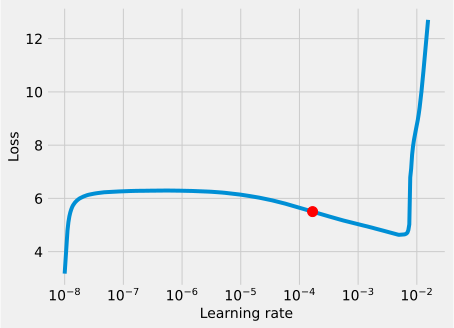

In [ ]:
trainer = pl.Trainer()
lr_finder = trainer.tuner.lr_find(model=my_model, train_dataloaders=train_dl, num_training=500)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

print (new_lr)

In [ ]:
predict_dl = DataLoader(train[torch.randint(1,100, (1,)).item()], batch_size=batch_size, shuffle=True)
idx = trainer.predict(my_model, predict_dl)
print (spb.Decode(idx[0].tolist())[0])


Predicting: 1854it [00:00, ?it/s]

?

All:
Resolved. resolved.

First Citizen:
First





























































































 of























































































































































































































































































































































































































In [ ]:
trainer.validate(my_model, val_dl)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.9074259400367737     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.9074259400367737}]

In [ ]:

%load_ext tensorboard

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.9074267148971558     │
└───────────────────────────┴───────────────────────────┘

Predicting: 0it [00:00, ?it/s]

ved. resolved.

First Citizen:
First, you know Caius Marcints some that let hims!
What now, not stci?
, are heho
Mentle no.
A plING weANkeed an of reril,

Fadord MER:
Wod? dain heartAN? but loPain Vold nen fa?pest cl haresrowolfordost speakom DUKE- Hast d anUSthurselly for the ten-:
The,it would as
 readd meght is for hafed, theilltholse
AKINGIUInd m no:
D such fow- resherih myghornisted by the wqunba thy mingnd sve


To her some:are:
Py lord al beoy butarA donelyENTIOukese all? b
pICgur. her
Fhan L OUid:
Aond he ourke to caul the both, be oor ticw:
Aay Oistro rercanouse theiones,
Weing himisoat hims, Duou and revef pour of withentm lo timeing but fwning him so

Hign, basiedyUvess' ond Whatenceigns, a witthebstoeer mle mlese her goy my king again whichn.

HOMH your theestnd, sirout wlesess theter,s a thanouheessis time we tn.
 andeacran,
Toer
 the had, thou hare speak comight;'mear to; so faand life s for him begose,
WENnYnessO
I good natch of my dter toy gu se reer.

CADThomjim than
 